                                                        Notebook 04 — Evaluation

This notebook evaluates the performance of the classification models trained in Notebook 03.

The objective is to assess how well each model predicts whether a crime results in an arrest using appropriate evaluation metrics and visualizations.

We evaluated 2 models:

- Logistic Regression

- Random Forest Classifier

The main objectifs are :

- Analyze predictions using a confusion matrix

- Compute classification metrics in detail

- Analyze performance using:

    - Confusion Matrix

    - Classification metrics

    - ROC Curve
    
- Compare models and select the best one

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)


The test datasets were generated and saved in Notebook 02 – Data Preparation.

In [7]:
X_test = pd.read_csv("../data/X_test.csv")
y_test = pd.read_csv("../data/y_test.csv").squeeze()

X_test.shape, y_test.shape

((269882, 41), (269882,))

The models were trained and saved in Notebook 03 – Modeling.

In [8]:
logistic_model = joblib.load("../models/logistic_model.pkl")
rf_model = joblib.load("../models/rf_model.pkl")

    Logistic Regression — Evaluation

**Predictions**

In [9]:
y_pred_log = logistic_model.predict(X_test)
y_prob_log = logistic_model.predict_proba(X_test)[:, 1]

**Confusion Matrix**

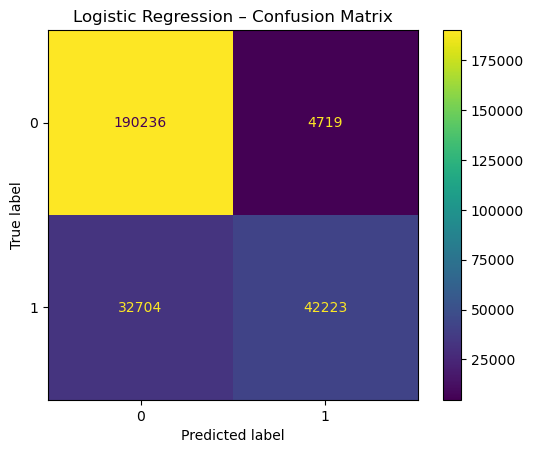

In [10]:
cm_log = confusion_matrix(y_test, y_pred_log)

ConfusionMatrixDisplay(cm_log).plot()
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

**ROC Curve**

In [11]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

    Random Forest — Evaluation

**Predictions**

In [12]:
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

**Confusion Matrix**

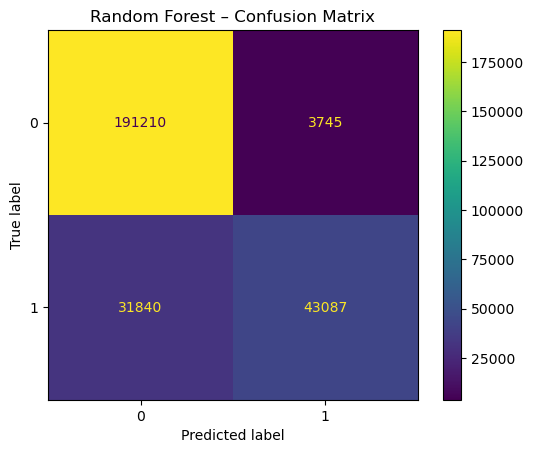

In [13]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest – Confusion Matrix")
plt.show()

Compared to Logistic Regression, Random Forest:

- Reduces false negatives

- Detects more arrests

- Provides a better balance between precision and recall

**ROC Curve**

In [14]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

    ROC Curve Comparison

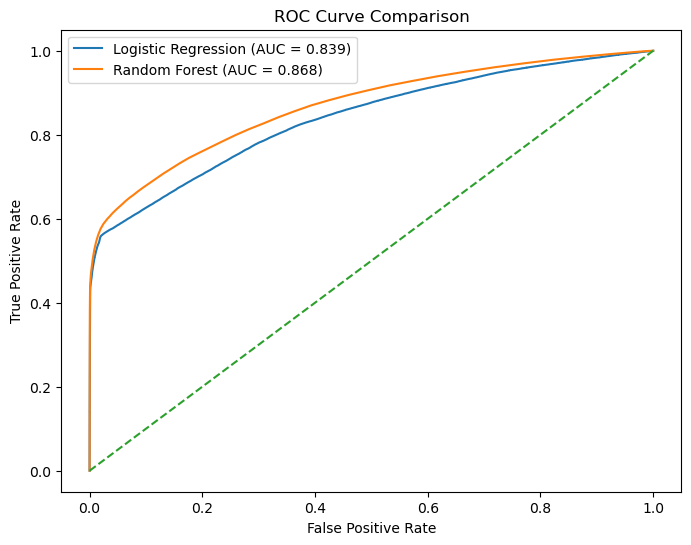

In [15]:
plt.figure(figsize=(8,6))

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
